<a href="https://colab.research.google.com/github/SwapnilAryan97/Time_series_Forecasting/blob/main/Time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Please open this file on google colab to see all the plottings not visible on github

# Packages

In [1]:
# Base
#--------------------------------------
import pandas as pd
import numpy as np
import os
import gc
import warnings

# Plotting
#--------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# PACF - ACF
#--------------------------------------
import statsmodels.api as sm

# CONFIGURATIONS
#--------------------------------------
warnings.filterwarnings('ignore')

# Machine Learning
#--------------------------------------
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Importing Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
transactions = pd.read_csv('transactions.csv').sort_values(['store_nbr', 'date'])

train['date'] = pd.to_datetime(train.date)
test['date'] = pd.to_datetime(test.date)
transactions['date'] = pd.to_datetime(transactions.date)

train['onpromotion'] = train.onpromotion.astype('float16')
train['sales'] = train.sales.astype('float16')
stores['cluster'] = stores.cluster.astype('int8')

train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0          0.0
1   1 2013-01-01          1   BABY CARE    0.0          0.0
2   2 2013-01-01          1      BEAUTY    0.0          0.0
3   3 2013-01-01          1   BEVERAGES    0.0          0.0
4   4 2013-01-01          1       BOOKS    0.0          0.0

In [3]:
# Removing 'inf' values from the sales column
count =0
for i in range(len(train['sales'])):
    if train['sales'][i]== float('inf') or train['sales'][i]== np.isnan: 
      train['sales'][i] = 0
      count+=1
print('count= ',count)

train['sales']

count=  4


0             0.00
1             0.00
2             0.00
3             0.00
4             0.00
            ...   
3000883     438.25
3000884     154.50
3000885    2420.00
3000886     121.00
3000887      16.00
Name: sales, Length: 3000888, dtype: float16

In [4]:
max(train['sales'])

63424.0

# Transactions

In [5]:
transactions.head()

date  store_nbr  transactions
1   2013-01-02          1          2111
47  2013-01-03          1          1833
93  2013-01-04          1          1863
139 2013-01-05          1          1509
185 2013-01-06          1           520

In [6]:
temp = pd.merge(train.groupby(['date', 'store_nbr']).sales.sum().reset_index(), transactions, how='left')
print('Spearman correlation between Total Sales and Transaction: {:,.4f}.'.format(temp.corr('spearman').sales.loc['transactions']))
px.line(transactions.sort_values(['store_nbr', 'date']), x='date', y='transactions', color='store_nbr', title='Transaction')

Spearman correlation between Total Sales and Transaction: 0.8167.


Here we can see that there are more transactions in Spring, and then they decline after that.
Now, to look at monthly based transaction...

In [7]:
temp_df = transactions.copy()
temp_df['year'] = temp_df.date.dt.year
temp_df['month'] = temp_df.date.dt.month
px.box(temp_df, x='year', y='transactions',color='month', title='Transaction')

There is a stable pattern in Transaction.
All months are more or less similar except December from 2013-2017 according to the bloxplot.

In [8]:
temp_df = transactions.set_index('date').resample('M').transactions.mean().reset_index()
temp_df['year'] = temp_df.date.dt.year
px.line(temp_df, x='date', y='transactions', color='year', title='Monthly average transaction')

In the above diagram, we can see the high correlation between total sales and transactions at the end of the year.

In [9]:
# px.scatter(temp, x='transactions', y='sales', trendline='ols', trendline_color_override = 'red')

Now, we look at the trend for everyday of the week

In [10]:
a = transactions.copy()
a['year'] = a.date.dt.year
a['dayofweek'] = a.date.dt.dayofweek+1
print(a.head())
a = a.groupby(['year', 'dayofweek']).transactions.mean().reset_index()
px.line(a, x='dayofweek', y='transactions', color='year', title='Transactions')
# a.head()

          date  store_nbr  transactions  year  dayofweek
1   2013-01-02          1          2111  2013          3
47  2013-01-03          1          1833  2013          4
93  2013-01-04          1          1863  2013          5
139 2013-01-05          1          1509  2013          6
185 2013-01-06          1           520  2013          7


The days of the week are important, this gives us a great insight on the pattern of transaction every week for every year. All the patterns from 2013-2017 are similar and have the highest transactions during the weekends, and saturday is the most important day for shopping.

# Oil Price

In [11]:
oil = pd.read_csv('oil.csv')
oil['date'] = pd.to_datetime(oil.date)
oil.isnull().sum().head(20)*100/len(oil)

date          0.000000
dcoilwtico    3.530378
dtype: float64

With the results above, we can see that dcoilwtico has only 3.5% missing data, which is acceptable for analyzing the data and does not really need any data imputation method. However, we can use linear interpolation for this time series.

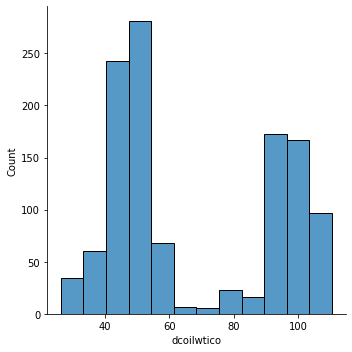

In [12]:
sns.displot(oil['dcoilwtico'])

The distribution plot shows us that the price has been between 40-60 for the majority of the time.


In [13]:
oil = oil.set_index('date').dcoilwtico.resample('D').sum().reset_index()
# Interpolation
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] =oil.dcoilwtico.interpolate()
# Plot
p = oil.melt(id_vars=['date']+list(oil.keys()[5:]), var_name='Legend')
px.line(p.sort_values(["Legend", "date"], ascending = [False, True]), x='date', y='value', color='Legend',title = "Daily Oil Price" )

The description tells us that Ecuador is an oil dependent country and it's sensitive to shocks in prices.
Below, we can see that the correlation values aren't that strong but the correlation is negetive, that means when the price of oil goes up, the sales goes decreases.

In [14]:
temp = pd.merge(temp, oil, how = 'left')
print("Correlation with Daily Oil Prices")
# print(temp)
print(temp.drop(["store_nbr", "dcoilwtico"], axis = 1).corr("spearman").dcoilwtico_interpolated.loc[["sales", "transactions"]], "\n")

Correlation with Daily Oil Prices
sales          -0.302649
transactions    0.040105
Name: dcoilwtico_interpolated, dtype: float64 



# Sales

Our main objective is to predict the store sales for every product family. For this reason, sales should be examined more seriously.
We need to learn everthing such as seasonality, trends, anomalies, similarities with other time series and so on.

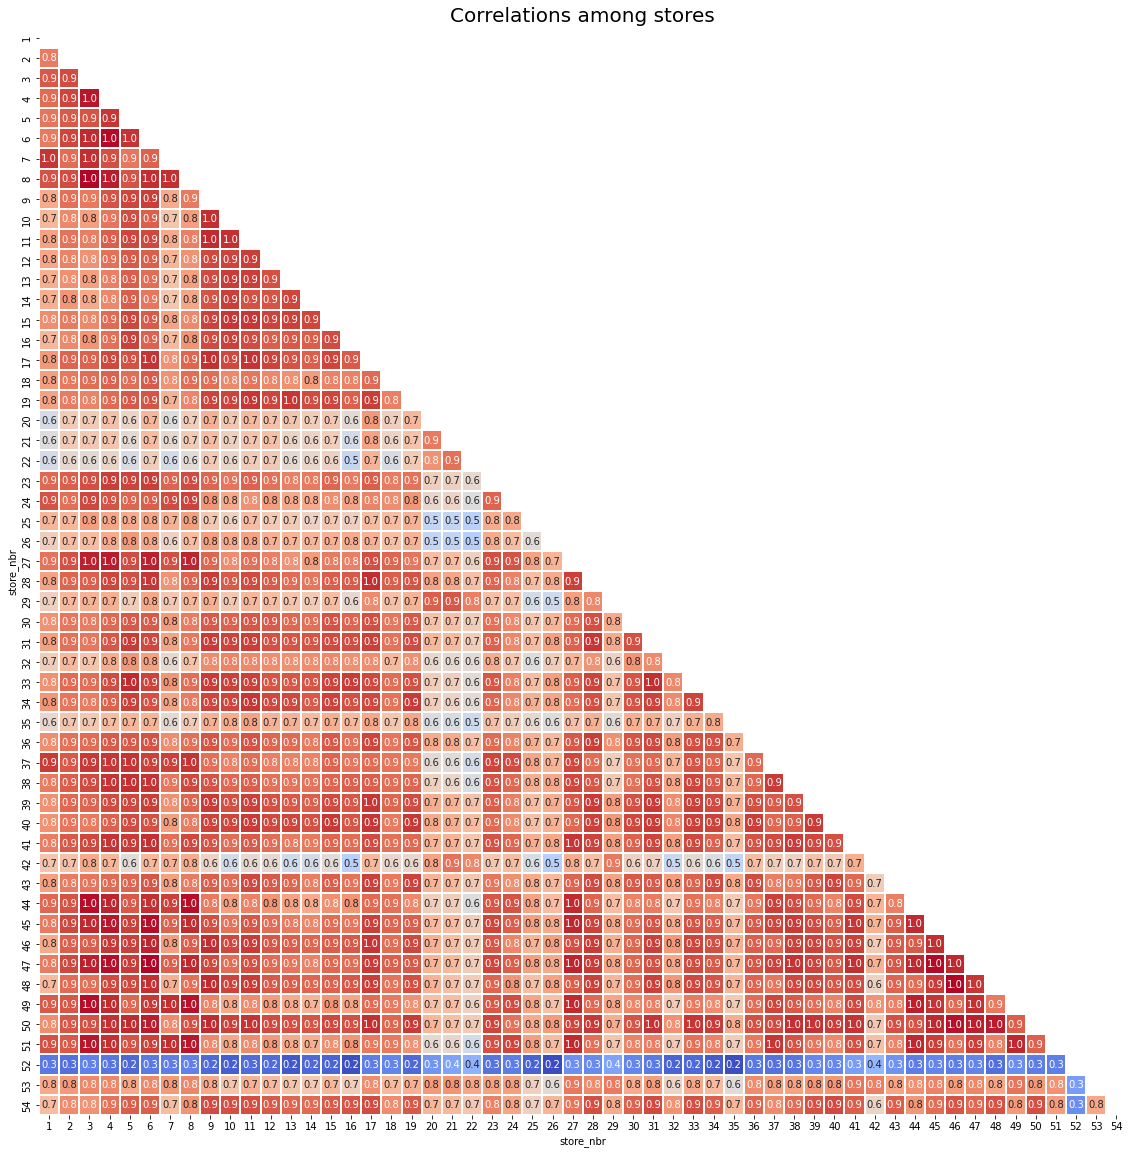

In [15]:
a = train[["store_nbr", "sales"]]
a["ind"] = 1
a["ind"] = a.groupby("store_nbr").ind.cumsum().values
a = pd.pivot(a, index = "ind", columns = "store_nbr", values = "sales").corr()
mask = np.triu(a.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Correlations among stores",fontsize = 20)
plt.show()

In [16]:
a = train.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores")

In [17]:
a = train.set_index("date").groupby("family").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "family", title = "Daily total sales of the family")

In [18]:
a = train.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
px.bar(a, y = "family", x="sales", color = "family", title = "Which product family preferred more?")

In [19]:
print("Spearman Correlation between Sales and Onpromotion: {:,.4f}".format(train.corr("spearman").sales.loc["onpromotion"]))

Spearman Correlation between Sales and Onpromotion: 0.7514


In [20]:
d = pd.merge(train, stores)
d["store_nbr"] = d["store_nbr"].astype("int8")
d["year"] = d.date.dt.year
px.line(d.groupby(["city", "year"]).sales.mean().reset_index(), x = "year", y = "sales", color = "city")

Since there is only a linear trend so far, we can use Multiple Linear Regression to predict the sales.

# Regression

In [21]:
train.describe()

id     store_nbr        sales  onpromotion
count  3.000888e+06  3.000888e+06  3000888.000    3000888.0
mean   1.500444e+06  2.750000e+01          NaN          NaN
std    8.662819e+05  1.558579e+01          NaN          NaN
min    0.000000e+00  1.000000e+00        0.000          0.0
25%    7.502218e+05  1.400000e+01        0.000          0.0
50%    1.500444e+06  2.750000e+01       11.000          1.0
75%    2.250665e+06  4.100000e+01      195.875         16.0
max    3.000887e+06  5.400000e+01    63424.000       1006.0

Formatting the training and testing data

In [22]:
x_train = train.iloc[:,[3, 5]].values
y_train = train.iloc[:,[4]].values

x_test = test.iloc[:,[3,4]].values

max(y_train)

array([63420.], dtype=float16)

In [23]:
x_train

array([['AUTOMOTIVE', 0.0],
       ['BABY CARE', 0.0],
       ['BEAUTY', 0.0],
       ...,
       ['PRODUCE', 148.0],
       ['SCHOOL AND OFFICE SUPPLIES', 10.0],
       ['SEAFOOD', 2.0]], dtype=object)

In [24]:
y_train

array([[   0.],
       [   0.],
       [   0.],
       ...,
       [2420.],
       [ 121.],
       [  16.]], dtype=float16)

*Encoding Categorical data*

In [25]:
le = LabelEncoder()
x_train[:,0] = le.fit_transform(np.array(x_train[:,0]))
x_test[:,0] = le.fit_transform(np.array(x_test[:,0]))
x_train

array([[0, 0.0],
       [1, 0.0],
       [2, 0.0],
       ...,
       [30, 148.0],
       [31, 10.0],
       [32, 2.0]], dtype=object)

# Ridge Regression

In [26]:
model = Ridge()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [27]:
y_pred

array([[ 239.75308031],
       [  80.65746863],
       [ 138.91421633],
       ...,
       [2589.35435272],
       [ 189.85749826],
       [ 131.07836014]])